In [55]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

import pykitti
import os


In [56]:
# load dataset with pykitti
# Load the data. Optionally, specify the frame range to load.
def load_dataset(date, drive, calibrated=False, frame_range=None):
    """
    Loads the dataset with `date` and `drive`.
    
    Parameters
    ----------
    date        : Dataset creation date.
    drive       : Dataset drive.
    calibrated  : Flag indicating if we need to parse calibration data. Defaults to `False`.
    frame_range : Range of frames. Defaults to `None`.

    Returns
    -------
    Loaded dataset of type `raw`.
    """
    #dataset = pykitti.raw(basedir, date, drive,frames=range(0, 20, 5))
    dataset = pykitti.raw(basedir, date, drive)
   
    
    # Load the data
    if calibrated:
        dataset._load_calib()  # Calibration data are accessible as named tuples

    np.set_printoptions(precision=4, suppress=True)
    print('\nDrive: ' + str(dataset.drive))
    print('\nFrame range: ' + str(dataset.frames))

    if calibrated:
        print('\nIMU-to-Velodyne transformation:\n' + str(dataset.calib.T_velo_imu))
        print('\nGray stereo pair baseline [m]: ' + str(dataset.calib.b_gray))
        print('\nRGB stereo pair baseline [m]: ' + str(dataset.calib.b_rgb))

    return dataset

In [57]:
# load dataset

#Path for Kitti Dataset

# basedir = '/home/'    # Location at Docker
basedir = '/home/'    # Location at Docker

# Specify the dataset to load
date = '2011_09_26'
drive = '0009'
load_dataset(date,drive,True)



Drive: 2011_09_26_drive_0009_sync

Frame range: None

IMU-to-Velodyne transformation:
[[ 1.      0.0008 -0.002  -0.8087]
 [-0.0008  0.9999 -0.0148  0.3196]
 [ 0.002   0.0148  0.9999 -0.7997]
 [ 0.      0.      0.      1.    ]]

Gray stereo pair baseline [m]: 0.537150600500771

RGB stereo pair baseline [m]: 0.5327254400790535


In [97]:
# set stereo Settings
def stereo_setting_disparity():
        
    ### START CODE HERE ###
    
    # Parameters
    num_disparities = 6*16
    block_size = 11
    
    min_disparity = 0
    window_size = 6

    # Stereo SGBM matcher
    stereo_matcher_SGBM = cv2.StereoSGBM_create(
        minDisparity=min_disparity,
        numDisparities=num_disparities,
        blockSize=block_size,
        P1=8 * 3 * window_size ** 2,
        P2=32 * 3 * window_size ** 2,
        mode=cv2.STEREO_SGBM_MODE_SGBM_3WAY
    )

    return stereo_matcher_SGBM


def compute_disparity_map(img_left, img_right, stereo_matcher_SGBM):
    # Compute the left disparity map
    disp_left = stereo_matcher_SGBM.compute(img_left, img_right).astype(np.float32)/16   
    return disp_left


def depth_from_disparity(disparity,k_,t_):
    
    # Get the focal length from the K matrix
    f = k_[0, 0]
    
    print("focal length of kitti lense:{}".format(f))
    # Get the distance between the cameras from the t matrices (baseline)
    #b = t_left[1] - t_right[1]
    
    b = 0.54  # Taken from the kitti website, looking into the sensor suite setup its 0.54 meters

    
    
    # Replace all instances of 0 and -1 disparity with a small minimum value (to avoid div by 0 or negatives)
    disparity[disparity == 0] = 0.1
    disparity[disparity == -1] = 0.1

    # Initialize the depth map to match the size of the disparity map
    depth_map = np.ones(disparity.shape, np.single)

    # Calculate the depths 
    depth_map[:] = f * b / disparity[:]
    
    return depth_map


def decompose_projection_matrix(P_matrix):
    
    ### START CODE HERE ###
    
    k, r, t, _, _, _, _ = cv2.decomposeProjectionMatrix(P_matrix)
    t = t / t[3]
    
    ### END CODE HERE ###
    
    return k, r, t

In [108]:

#Compute the disparity map
# Calling the settings for stereo disparity matcher
stereo_matcher_SGBM = stereo_setting_disparity()
#computer the disparity using stereo images

frame =10
img_left_rgb = np.array(dataset.get_cam2(frame))
img_right_rgb = np.array(dataset.get_cam3(frame))

# converting RGB to Grey images for computing disparity map
img_left_grey = cv2.cvtColor(img_left_rgb , cv2.COLOR_RGB2GRAY)
img_right_grey = cv2.cvtColor(img_right_rgb , cv2.COLOR_RGB2GRAY)


disparaity_map = compute_disparity_map(img_left_grey, img_right_grey,stereo_matcher_SGBM)


In [109]:
# Read the calibration 
P_matrix=  dataset.calib.P_rect_00

# Decompose each matrix
k_, r_, t_ = decompose_projection_matrix(P_matrix)

# Display the matrices
# print("P_matrix")
# print(P_matrix)


# print("decompouse matrics")
# print("k_ \n", k_)
# print("\nr_ \n", r_)
# print("\nt_ \n", t_)

In [110]:
# Get the depth map by calling the above function
depth_map= depth_from_disparity(disparaity_map, k_, t_)


<ipython-input-97-f1dd2b12537d>:51: RuntimeWarning: divide by zero encountered in true_divide
  depth_map[:] = f * b / disp_left[:]


In [111]:
def visualize():
    # Display some data
    f, ax = plt.subplots(2, 2, figsize=(15, 5))
    ax[0, 0].imshow(img_left_rgb)
    ax[0, 0].set_title('Left RGB Image (cam2)')

    ax[0, 1].imshow(img_right_rgb)
    ax[0, 1].set_title('Right RGB Image (cam3)')

    ax[1, 0].imshow(disparaity_map,cmap='gray')
    ax[1, 0].set_title('RGB Stereo Disparity')

    ax[1, 1].imshow(depth_map, cmap='flag')
    ax[1, 1].set_title('RGB Stereo Depth')

    plt.show()

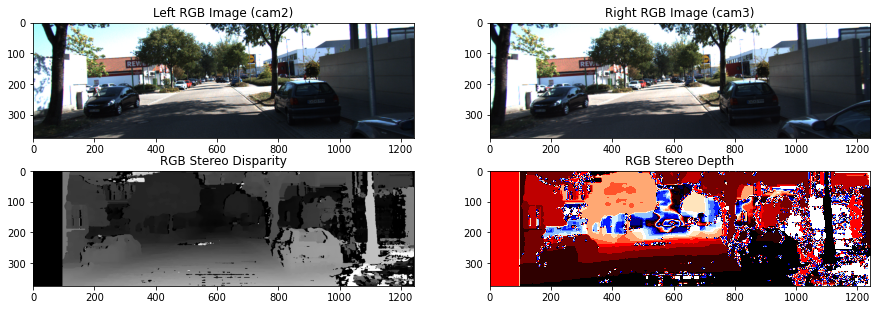

In [107]:
visualize()